In [21]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models, applications
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.layers import BatchNormalization, Dropout, GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import SGD, RMSprop
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import VGG16,ResNet50,ResNet50V2
import os

In [3]:
# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Define paths
train_dataset_path = "F:\\archive\\data\\puzzle_2x2\\train\\"
train_label_path = "F:\\archive\\data\\puzzle_2x2\\train_filtered.csv"

test_dataset_path = "F:\\archive\\data\\puzzle_2x2\\test\\"
test_label_path = "F:\\archive\\data\\puzzle_2x2\\test.csv"

validation_dataset_path = "F:\\archive\\data\\puzzle_2x2\\valid\\"
validation_label_path = "F:\\archive\\data\\puzzle_2x2\\valid.csv"

def load_data(dataset_path, label_path, percentage=100):
    df = pd.read_csv(label_path)
    images = []
    labels = []

    # Select a subset of data based on the percentage
    num_samples = int(len(df) * (percentage / 100))
    df = df.head(num_samples)

    for index, row in df.iterrows():
        image_name = row['image']  # Get the image name from the dataframe
        image_path = os.path.join(dataset_path, image_name)  # Construct the full image path
        image = tf.keras.preprocessing.image.load_img(image_path, target_size=(100, 100))
        image = tf.keras.preprocessing.image.img_to_array(image)
        images.append(image)

        # Convert label permutation to integer index
        label_permutation = [int(x) for x in row['label'].split()]
        label_index = get_permutation_index(label_permutation)
        
        labels.append(label_index)

    return np.array(images), np.array(labels)

def get_permutation_index(perm):
    # Define all possible permutations of [0, 1, 2, 3]
    permutations = [
        [0, 1, 2, 3], [0, 1, 3, 2], [0, 2, 1, 3], [0, 2, 3, 1],
        [0, 3, 1, 2], [0, 3, 2, 1], [1, 0, 2, 3], [1, 0, 3, 2],
        [1, 2, 0, 3], [1, 2, 3, 0], [1, 3, 0, 2], [1, 3, 2, 0],
        [2, 0, 1, 3], [2, 0, 3, 1], [2, 1, 0, 3], [2, 1, 3, 0],
        [2, 3, 0, 1], [2, 3, 1, 0], [3, 0, 1, 2], [3, 0, 2, 1],
        [3, 1, 0, 2], [3, 1, 2, 0], [3, 2, 0, 1], [3, 2, 1, 0]
    ]
    # Find the index of the given permutation in the list of permutations
    index = permutations.index(perm)
    return index


In [4]:
# Example usage:
train_images, train_labels = load_data(train_dataset_path, train_label_path, percentage=100)
test_images, test_labels = load_data(test_dataset_path, test_label_path, percentage=100)
validation_images, validation_labels = load_data(validation_dataset_path, validation_label_path, percentage=100)
print(train_labels.shape)

# Normalize pixel values to be between 0 and 1
train_images = train_images / 255.0
test_images = test_images / 255.0
validation_images = validation_images / 255.0

(21600,)


In [22]:

# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Model Checkpoint
checkpoint = ModelCheckpoint('best_2x2_ResNetV2_50_model.h5', monitor='val_accuracy', save_best_only=True)

# Learning Rate Scheduler
def lr_scheduler(epoch, lr):
    if epoch and epoch % 4 == 0:
        return lr * 0.8  # Reduce learning rate by 20% every 4 epochs
    return lr

lr_scheduler_callback = LearningRateScheduler(lr_scheduler)

# Define the base model (ResNetV2-50) without top layers
base_model = ResNet50V2(input_shape=(100, 100, 3), weights='imagenet', include_top=False)

# Freeze the base model layers
for layer in base_model.layers[:-12]:
    layer.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)  # L2 regularization
x = BatchNormalization()(x)  # Batch normalization
x = Dropout(0.5)(x)  # Dropout regularization
output = Dense(24, activation='softmax')(x)

# Create the final model
model = models.Model(inputs=base_model.input, outputs=output)

# Compile the model with Adam optimizer and categorical cross-entropy loss
model.compile(optimizer=Adam(learning_rate=0.001),  # Adam optimizer
              loss='sparse_categorical_crossentropy',  # Sparse categorical cross-entropy
              metrics=['accuracy'])

# Train the model with batch normalization, dropout, and Adam optimizer
history = model.fit(
    train_images, train_labels, 
    batch_size=256,
    epochs=50,
    validation_data=(validation_images, validation_labels),
    callbacks=[early_stopping, checkpoint, lr_scheduler_callback],
    verbose=1)

# Evaluate the model on test data 
test_loss, test_acc = model.evaluate(test_images, test_labels)

# Save the final model
model.save('final_2x2_ResNetV2_50_model.h5')

# Load the best model
best_model = models.load_model('best_2x2_ResNetV2_50_model.h5')

# Evaluate the best model
best_model_loss, best_model_acc = best_model.evaluate(test_images, test_labels)

# Predict labels for test data
predictions = best_model.predict(test_images)
predicted_permutations = np.argmax(predictions, axis=1)  # Get the index of the highest probability for each sample



94668760/94668760 [==============================] - 159s 2us/step
Epoch 1/50
85/85 [==============================] - ETA: 0s - loss: 8.1378 - accuracy: 0.1143

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


85/85 [==============================] - 298s 3s/step - loss: 8.1378 - accuracy: 0.1143 - val_loss: 5.4549 - val_accuracy: 0.1688 - lr: 0.0010
Epoch 2/50
85/85 [==============================] - 258s 3s/step - loss: 3.6685 - accuracy: 0.3664 - val_loss: 2.9664 - val_accuracy: 0.3584 - lr: 0.0010
Epoch 3/50
85/85 [==============================] - 262s 3s/step - loss: 1.9817 - accuracy: 0.5991 - val_loss: 2.3095 - val_accuracy: 0.4571 - lr: 0.0010
Epoch 4/50
85/85 [==============================] - 262s 3s/step - loss: 1.0947 - accuracy: 0.7803 - val_loss: 2.0722 - val_accuracy: 0.4519 - lr: 0.0010
Epoch 5/50
85/85 [==============================] - 257s 3s/step - loss: 0.5179 - accuracy: 0.9267 - val_loss: 2.0128 - val_accuracy: 0.4494 - lr: 8.0000e-04
Epoch 6/50
85/85 [==============================] - 263s 3s/step - loss: 0.2574 - accuracy: 0.9772 - val_loss: 1.8553 - val_accuracy: 0.4649 - lr: 8.0000e-04
Epoch 7/50
85/85 [==============================] - 258s 3s/step - loss: 0.1520

OSError: No file or directory found at best_2x2_ResNetV2_50_model.h5

In [24]:
# Load the best model
best_model = models.load_model('best_2x2_ResNetV2_50_model.h5')

# Evaluate the best model
best_model_loss, best_model_acc = best_model.evaluate(test_images, test_labels)

# Predict labels for test data
predictions = best_model.predict(test_images)
predicted_permutations = np.argmax(predictions, axis=1)  # Get the index of the highest probability for each sample

68/68 [==============================] - 25s 356ms/step


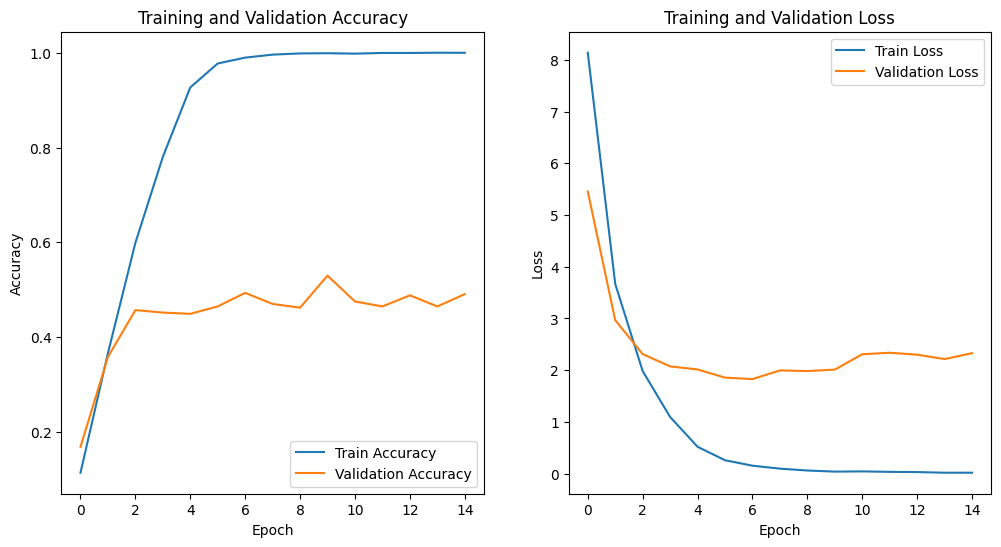

In [25]:
# Plot the training and validation accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot the training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Save the plots
plt.savefig('2x2_ResNetV2_training_plots.png')

# Write final testing accuracy to a text file
with open('2x2_ResNetV2_testing_accuracy.txt', 'w') as f:
    f.write('Final Test accuracy: {:.4f}\n'.format(test_acc))
    f.write('Best Model Test accuracy: {:.4f}\n'.format(best_model_acc))
